In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np

my_data = pd.read_csv('train.csv')

# Тестовое задание - Елькин СВ

### загрузим данные, посмотрим, что там

In [2]:
my_data

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


### перемешаем данные - будет полезно при обучении

In [3]:
my_data = my_data.sample(frac = 1) 

In [4]:
my_data

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
118,conductor,ebaf02a6,2020-04-24T15:16:27,Trudy,secure webservice ip,2
126,conductor,a6b4a5c5,2020-04-17T13:27:01,Mallory,added service hashsum,2
305,sensor,ebada797,2020-03-28T13:10:53,Mallory,copy filebeat configs revucrsive,3
160,conductor,5f1270b2,2020-04-01T14:43:38,Mallory,trap ports,2
197,conductor,ad61541d,2020-03-13T17:06:09,Dabe,initial commit,2
...,...,...,...,...,...,...
255,sensor,79c65340,2020-04-29T08:55:13,Victor,Авторизация в докер регистре,3
212,dockers,4629cb29,2020-04-15T13:47:21,Mallory,removed filebeat from traps,3
306,sensor,57b752ce,2020-03-28T12:52:45,Mallory,Get filebeat from elastic repository,3
275,sensor,287750a4,2020-04-15T14:42:36,Victor,python3-dev to install requirements,3


### взглянем, что как распределены баги в репозиториях

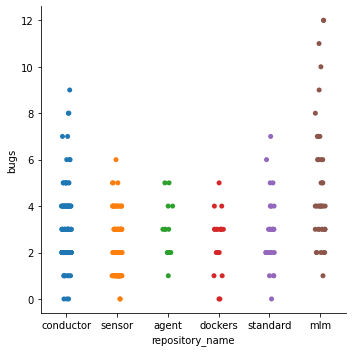

In [5]:
sns.catplot(x='repository_name',
            y='bugs',
            data=my_data);

### как связано количество багов и авторов

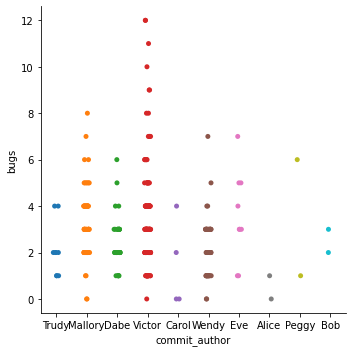

In [6]:
sns.catplot(x='commit_author',
            y='bugs',
            data=my_data);

### глянем, как связаны авторы и баги, подсветив репозитории

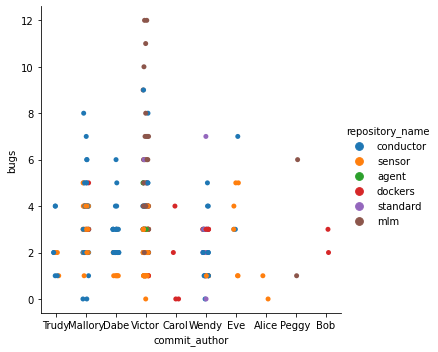

In [7]:
sns.catplot(x='commit_author',
            y='bugs',
            hue='repository_name',
            data=my_data);

## Что мы имеем и что можно предположить
#### Я предположу, что можно построить модель линейной регрессии - предположить значение параметра bugs по введенным параметрам
**Сложности** <br>
1 - почти все параметры - категориальные признаки <br>
2 - признаков несколько - какие выбрать

## Каков план
Я буду тестировать гипотезу, что на количество багов могут влиять такие факторы как "автор" и "репозиторий" <br>
Первым делом применим встроеный метод one-hot encoding.


In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
repository_to_vector = LabelBinarizer()
repository_to_vector.fit(my_data['repository_name'])
transformed = repository_to_vector.transform(my_data['repository_name'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['repository_name'], axis=1)

In [10]:
commit_to_vector = LabelBinarizer()
commit_to_vector.fit(my_data['commit_author'])
transformed = commit_to_vector.transform(my_data['commit_author'])
new_df = pd.DataFrame(transformed)
my_data = pd.concat([my_data, new_df], axis=1).drop(['commit_author'], axis=1)

### Взглянем, что получилось

In [11]:
my_data

,commit_hash,commit_date,commit_message,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
0,b28abb42,2020-06-12T14:26:12,объяснения предсказаний с помощью lime,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,438b5c4d,2020-06-12T11:53:10,Поставил lime вместо eli5,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8e6e4f31,2020-06-11T15:19:03,Скрипт для создния пакетов обновления,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,5e0956a6,2020-06-11T10:42:29,Сортировка весов по убыванию,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,b9f4b40c,2020-06-11T09:25:19,не надо конвертировать массив до операции по с...,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,5b1ecbcd,2020-03-23T12:54:35,setting hostname,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
315,a3f5b753,2020-03-23T12:30:52,heralding default dockerfile,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
316,e8155942,2020-03-23T11:27:40,unnesserity /data path permissions setting,3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
317,e748af51,2020-03-23T11:20:50,added trapconductor,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


### Выкинем другие столбцы, кроме "багов"

In [12]:
my_data = my_data.drop(['commit_hash','commit_date','commit_message'], axis=1)

### Посмотрим, что получилось

In [13]:
my_data

,bugs,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
315,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
316,3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
317,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


###  Начнем строить нашу модель - добавим библиотеку и сделаем тренировочную и тестовую выборку

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
model = LinearRegression(fit_intercept=True)

In [16]:
checker = my_data['bugs']

In [17]:
my_data.drop(['bugs'], axis=1)

,0,1,2,3,4,5,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
315,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
316,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
317,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [18]:
train_data = my_data[:-45]
train_label = checker[:-45]
test_data = my_data[-45:]
test_label = checker[-45:]

### Протренируем нашу модель

In [19]:
model.fit(train_data, train_label)

LinearRegression()

In [20]:
model.intercept_

-2.6645352591003757e-15

In [21]:
model.coef_

array([ 1.00000000e+00, -5.15541688e-18, -1.48558460e-17,  3.15811395e-18,
       -2.92237162e-17,  2.60756211e-17,  1.23935825e-17,  6.01465495e-19,
        9.16068016e-18, -1.37748216e-16, -1.83859523e-17, -2.57234144e-17,
       -1.07476812e-17,  1.00057206e-16,  3.44795041e-17,  7.05994165e-17,
       -2.78183553e-17])

### Смещение и веса выстроены. Проверим, насколько хорошо это нам получилось
Для этого будем использовать *коэффициент детерминации* - он же $ R^2 $ - чем ближе к 1, тем точнее

In [22]:
from sklearn.metrics import r2_score

In [23]:
predicted_data = model.predict(test_data)

In [24]:
r2_score(predicted_data, test_label)

1.0

### Данные удалось отлично описать - значит данные жестко детерминированы
#### Давайте посмотрим, что похожи ли последние 10 предсказаных багов и то, как в реальности даны

In [25]:
predicted_data[-10:]

array([2., 1., 1., 1., 1., 1., 2., 3., 1., 1.])

In [26]:
test_label[-10:]

309    2
310    1
311    1
312    1
313    1
314    1
315    2
316    3
317    1
318    1
Name: bugs, dtype: int64

### На все уточняющие вопросы готов ответить)